In [1]:
import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

466
156
{'meta': {'AgeInMonths': 146, 'Gender': 'F', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 2, 'AgeGroupEdge1': 144, 'AgeGroupEdge2': 180}, 'rest': '30', 'nback': '31', 'emoid': '31', 'ID': 600262185931}


In [4]:
# Load wrat

idWratDict = {}

with open('../../wrat.csv') as f:
    for line in f.readlines()[1:]:
        parts = line.split(',')
        try:
            idWratDict[int(parts[0])] = int(parts[3])
        except Exception as e:
            print(parts[0])
            print(e)

603056110671
invalid literal for int() with base 10: 'NaN\n'
603317055381
invalid literal for int() with base 10: 'NaN\n'
604847970437
invalid literal for int() with base 10: 'NaN\n'


In [130]:
import numpy as np

train_wrat = []
test_wrat = []
wrat_ids = idWratDict.keys()
y_train = []
y_test = []

# 1. Wrat (neighbors) 2. Age 3/4. Male/Female
feat_train = []
feat_test = []

for subj in train:
    if subj['ID'] in wrat_ids:
        train_wrat.append(subj)
        y_train.append(idWratDict[subj['ID']])
        male = 1 if subj['meta']['Gender'] == 'M' else 0
        female = 1 if male == 0 else 0
        feat_train.append(np.array([y_train[-1], subj['meta']['AgeInMonths']]))#, male, female]))
        
for subj in test:
    if subj['ID'] in wrat_ids:
        test_wrat.append(subj)
        y_test.append(idWratDict[subj['ID']])
        male = 1 if subj['meta']['Gender'] == 'M' else 0
        female = 1 if male == 0 else 0
        feat_test.append(np.array([y_train[-1], subj['meta']['AgeInMonths']]))#, male, female]))

y_train = np.array(y_train)
y_test = np.array(y_test)
feat_train = np.vstack(feat_train)
feat_test = np.vstack(feat_test)

print(feat_train.shape)
print(feat_test.shape)
print(y_train.shape)
print(y_test.shape)
print(len(train_wrat))
print(len(test_wrat))

(446, 2)
(148, 2)
(446,)
(148,)
446
148


In [131]:
print(feat_train[9,:])

[145 181]


In [13]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train_wrat]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test_wrat]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [16]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [17]:
# Calculare pearson matrices

train_p = [np.corrcoef(sub) for sub in train_rest_ts]
test_p = [np.corrcoef(sub) for sub in test_rest_ts]

print('Complete')

Complete


In [23]:
# Calculate edge weights
import math

def calc_e(p):
    N = len(p)
    e = np.zeros([N,N])
    print('Done', end=' ')
    for i in range(N):
        print(i, end=' ')
        e[i,i] = 0
        for j in range(i+1,N):
            d = np.linalg.norm(p[i]-p[j])
            e[i,j] = d
            e[j,i] = d
            
    print('Finished!')
    return e

train_e = calc_e(train_p)

Done 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 2

In [143]:
# Get the means and stds for the timeseries

print(train_rest_ts[0].shape)

def getMuSigma(all_ts):
    means = []
    stds = []
    for ts in all_ts:
        means.append(ts.mean(axis=0))
        stds.append(ts.std(axis=0))
    means = np.vstack(means)
    stds = np.vstack(stds)
    return means, stds

train_mu, train_std = getMuSigma(train_rest_ts)
test_mu, test_std = getMuSigma(test_rest_ts)

print(train_mu.shape)
print('Complete')

(264, 210)
(446, 210)
Complete


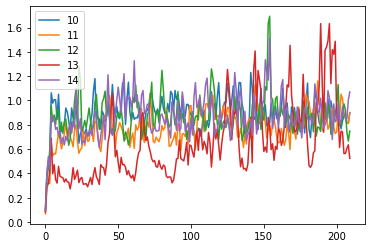

In [148]:
for i in range(10,15):
    plt.plot(train_std[i,:], label=i)
    
plt.legend()
plt.show()

In [132]:
def normalizedA(A):
    d = np.sum(A,axis=0)
    d[d == 0] = 1e-5
    d1 = d**0.5
    return ((A/d1).T/d1).T

def binarize(A, pctGone):
    N = A.shape[0]
    A = A.reshape([N*N])
    idcs = np.argsort(A)
    start = math.ceil(pctGone*len(idcs))
    Abin = np.zeros([N*N])
    Abin[idcs[start:]] = A[idcs[start:]]
    Abin = Abin.reshape([N,N])
    return Abin

train_e1 = train_e / np.max(train_e)
train_e1 = 1 - train_e1
train_e1 -= np.eye(train_e1.shape[0])

degree_e1 = np.sum(train_e1,axis=0)
# train_e1 = binarize(train_e1, 0.8)
train_e1 = normalizedA(train_e1)

# Make a dummy row/col
# train_e1 = np.vstack([train_e1, np.zeros([1,train_e1.shape[0]])])
# train_e1 = np.hstack([train_e1, np.zeros([train_e1.shape[0],1])])

print(train_e1.shape)
print('Complete')

(446, 446)
Complete


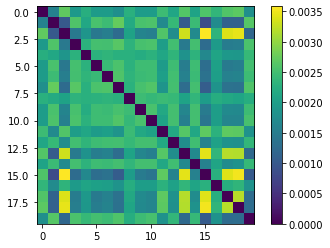

98.50541901041798
98.50541901041798


In [82]:
plt.imshow(train_e1[0:20,0:20])
plt.colorbar()
plt.show()

a,b = np.where(train_e1 > 0)
print(train_e[a[0],b[0]])
print(train_e[0,1])

In [133]:
# Get training wrat GCN messages

nFeat = feat_train.shape[1]
X_wrat = np.ones([feat_train.shape[0],6*nFeat+1])

for i in range(feat_train.shape[0]):
    wratSav = feat_train[i,0]
    feat_train[i,0] = 0
    a = feat_train
    for j in range(6):
        a = train_e1@a
        X_wrat[i,j*nFeat:(j+1)*nFeat] = a[i,:]
    feat_train[i,0] = wratSav
    
print(X_wrat[-3,:])

[100.56523825 178.40388582 100.58732431 177.49626807 100.63985877
 177.35944078 100.64702264 177.34066435 100.64800581 177.33808981
 100.64814061 177.33773685   1.        ]


In [134]:
# Get test wrats GCN messages

nFeat = feat_train.shape[1]
X_wrat_test = np.ones([len(test_p),6*nFeat+1])

for i in range(len(test_p)):
    # Calculate distances
    ds = np.zeros([len(train_p),1])
    dsp1 = np.zeros([1,len(train_p)+1])
    
    for j in range(len(train_p)):
        ds[j,0] = np.linalg.norm(test_p[i]-train_p[j]) 
        dsp1[0,j] = ds[j,0]
         
    train_e1 = np.hstack([train_e, ds])
    train_e1 = np.vstack([train_e1, dsp1])
    
    train_e1 = train_e1 / np.max(train_e1)
    train_e1 = 1 - train_e1
    train_e1 -= np.eye(train_e1.shape[0])
    
#     train_e1 = binarize(train_e1, 0.8)
    train_e1 = normalizedA(train_e1)
    
    # Find diffusion ages
    tstRow = feat_test[i,:]
    wratSav = tstRow[0]
    tstRow[0] = 0
    a = np.vstack([feat_train, tstRow])
    tstRow[0] = wratSav
    for j in range(6):
        a = train_e1@a
        X_wrat_test[i,j*nFeat:(j+1)*nFeat] = a[i,:]
    
    print(i, end=' ')

print()
print('Complete')
print(X_wrat_test[-1,:])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 
Complete
[105.53252933 186.07249735 105.58724007 186.03061247 105.59340425
 186.01095349 105.59423987 186.00829275 105.59435408 186.00792855
 105.59436971 186.00787872   1.        ]


In [139]:
# Regress on wrat with and without GCN

def make3rdOrderPoly(ps):
    fi = np.vstack([p.flatten() for p in ps])
    se = fi**2
    th = fi**3
    return np.hstack([fi, se, th])

# Xtrain = np.vstack([p.flatten() for p in train_p])
Xtrain = make3rdOrderPoly(train_p)
# Xtrain = np.hstack([X_wrat, Xtrain])
# Xtrain = X_wrat
print('Done pearson')

# w, r, _, _ = np.linalg.lstsq(Xtrain.T@Xtrain + 1*np.eye(Xtrain.shape[1]), Xtrain.T@y_train, rcond=None)
w, r, _, _ = np.linalg.lstsq(Xtrain, y_train, rcond=None)

print(r)
print('Complete')

Done pearson
[]
Complete


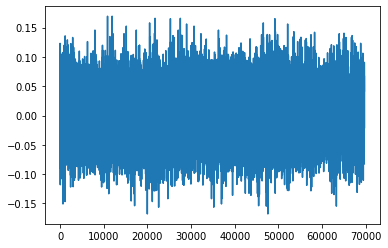

In [125]:
plt.plot(w)
plt.show()

Done pearson
[[1.        0.3760661]
 [0.3760661 1.       ]]
16.187103947186237
12.695361082596204


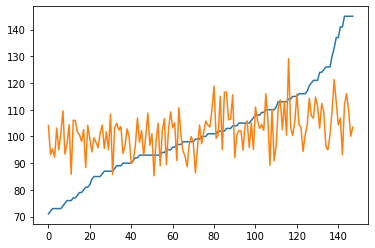

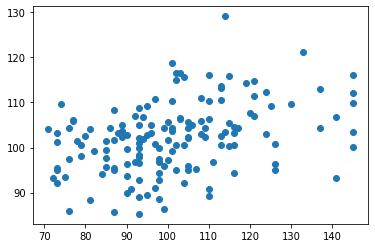

In [140]:
import matplotlib.pyplot as plt

# y = y_train

# # X = np.vstack([p.flatten() for p in train_p])
# # X = make3rdOrderPoly(train_p)
# # X = np.hstack([X_wrat, X])
# X = X_wrat
# print('Done pearson')

# yPred = X@w

y = y_test

# X = np.vstack([p.flatten() for p in test_p])
X = make3rdOrderPoly(test_p)
# X = np.hstack([X_wrat_test, X])
# X = X_wrat_test
print('Done pearson')

yPred = X@w

idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5
mae = np.sum(np.abs(y-yPred))/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

[[1.         0.19250525]
 [0.19250525 1.        ]]
15.091531411607427
11.852746636771302


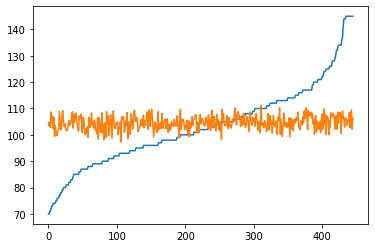

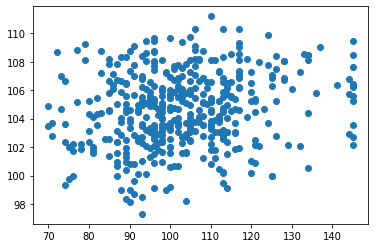

In [119]:
# KNN
# Take average ages of K nearest neighbors

k = 40
yPred = np.zeros(y_train.shape[0])
y = y_train.flatten()

for i in range(len(train_p)):
    row = train_e[i,:]
    idcs = np.argsort(row)[1:k+1]
    wrats = y_train[idcs]
    pred = sum(wrats)/len(wrats)
    yPred[i] = pred
    
idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]
    
corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5
mae = np.sum(np.abs(y-yPred))/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()